# <CENTER> **Data Mining**
# <center> PROJECT 2


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# **Question 1: Study over time**
We import the model, read the data and create a Dataset.csv file which contains all the reviews from the dataset.

In [2]:
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    top_k = None
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [10]:
import pandas as pd


df = pd.read_csv("/content/gdrive/MyDrive/τεδε/data/2019/april/reviews.csv",low_memory=False)
april_reviews = df['comments']

df = pd.read_csv('/content/gdrive/MyDrive/τεδε/data/2019/febrouary/reviews.csv',low_memory=False)
february_reviews = df['comments']

df = pd.read_csv('/content/gdrive/MyDrive/τεδε/data/2019/march/reviews.csv',low_memory=False)
march_reviews = df['comments']

df = pd.concat( [april_reviews, february_reviews, march_reviews] , ignore_index=True)

# drop empty rows
df.dropna(inplace=True)

df.to_csv("Dataset.csv", index=False)

<center><h3><b>Pre-processing</b></h3></center>
In this part of the code, we pre-process the data in the following way: firstly we only keep the english comments as instructed, then we convert everything to lowercase, remove url's, remove hashtags (#) and references (@), remove emoji's and finally remove stopwords.

In [11]:
#!pip install langdetect
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from langdetect import detect

# Download the stopwords from NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')


# Function to preprocess the text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove emojis by filtering out characters outside the ASCII range
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    #stop_words = set()
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # Reconstruct the text
    text = ' '.join(filtered_text)
    return text

# Define the function to detect English
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False


df = pd.read_csv('Dataset.csv',low_memory=False)

#fraction_df = df.sample(frac=0.03)
fraction_df=df.head(2500)
# Apply the function to the sentences column
fraction_df['is_english'] = fraction_df['comments'].apply(is_english)  # replace 'sentences' with your column name

# Filter the DataFrame
fraction_df = fraction_df[fraction_df['is_english']]
fraction_df = fraction_df.drop(columns=['is_english'])

# Apply the preprocessing function to each review
fraction_df['comments'] = fraction_df['comments'].apply(lambda x: preprocess_text(str(x)))

fraction_df.to_csv('reviews.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-11-f6c81b057e65>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraction_df['is_english'] = fraction_df['comments'].apply(is_english)  # replace 'sentences' with your column name


<center><h3><b>Sentiment Classification</b></h3></center>
Here, we load the tokenizer of our imported model, and then we load each review to get its sentiment, which we place on a new column "sentiment". We get that sentiment from firstly truncating our sentence (in case it contains more words than the model requires as input), tokenizing it then get its sentiment and store it in string form.

In [12]:
from transformers import AutoTokenizer

fraction_df = pd.read_csv('reviews.csv',low_memory=False)

# Load the tokenizer corresponding to your model
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

def get_sentiment(review_text):

    # Truncate the review text to 512 tokens
    review_text = review_text[:512]

    # Tokenize the review text
    tokens = tokenizer.tokenize(review_text)

    # Convert tokens back to a string
    truncated_text = tokenizer.convert_tokens_to_string(tokens)

    # Use the sentiment classifier on the truncated review text
    results = distilled_student_sentiment_classifier(truncated_text)

    # Sort the results by score in descending order and get the label of the first result
    top_result = sorted(results[0], key=lambda x: x['score'], reverse=True)[0]['label']
    return top_result


# Apply the get_sentiment function to each review in the DataFrame
fraction_df['sentiment'] = fraction_df['comments'].astype(str).apply(get_sentiment)

fraction_df.to_csv('reviews.csv', index=False)

This is a step which is necessary for balancing the dataset. Because the number of positive comments is overwhelming, and the number of neutral comments for example is minuscule, instead of scanning for specific words (which could lead to unwanted behaviour since for example "not good" should not be categorized as positive if we are searching for the "good" word), we simply duplicate the number of neutral and negative comments to make up for 10% of the positive comments, just to make the process better and to "extract" better generalization from the model. This helped also with later use of the 10-fold cross validation method.

In [13]:
from sklearn.utils import resample

fraction_df = pd.read_csv('reviews.csv',low_memory=False)

# Separate the comments by sentiment
positive = fraction_df[fraction_df.sentiment == 'positive']
negative = fraction_df[fraction_df.sentiment == 'negative']
neutral = fraction_df[fraction_df.sentiment == 'neutral']

# Calculate the number of comments to sample for negative and neutral
n_samples = len(positive) // 10

# Resample negative and neutral comments
negative_resampled = resample(negative, replace=True, n_samples=n_samples, random_state=123)
neutral_resampled = resample(neutral, replace=True, n_samples=n_samples, random_state=123)

# Combine the resampled groups with the original positive comments
balanced_df = pd.concat([positive, negative_resampled, neutral_resampled])

# Shuffle the order of the comments
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

# Save the balanced dataset to a CSV file
balanced_df.to_csv('reviews.csv', index=False)

**Sentiment Distribution Plot**

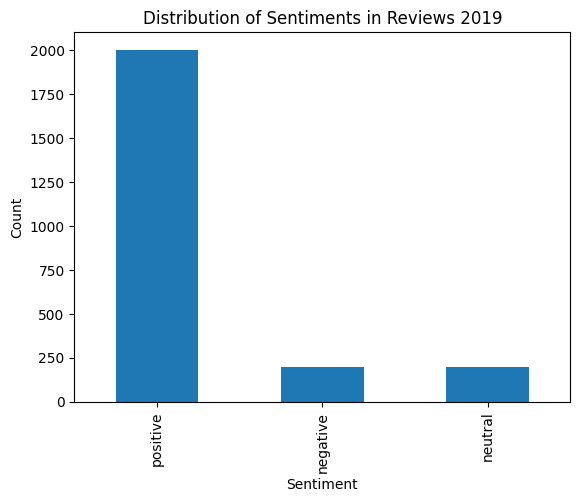

In [14]:
#print histogram of sentiments
import matplotlib.pyplot as plt

fraction_df = pd.read_csv('reviews.csv',low_memory=False)
fraction_df['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Reviews 2019')
plt.show()

**Now, we do the same for 2023 reviews**

<ipython-input-15-bdf58a415b9c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraction_df['is_english'] = fraction_df['comments'].apply(is_english)  # replace 'sentences' with your column name


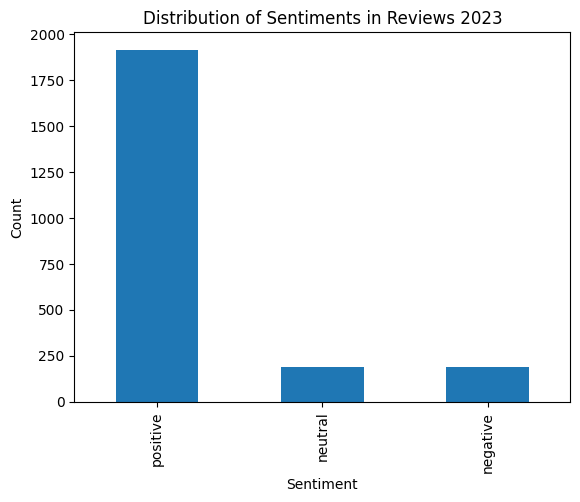

In [15]:
df = pd.read_csv('/content/gdrive/MyDrive/τεδε/data/2023/june/reviews.csv',low_memory=False)
june_reviews = df['comments']

df = pd.read_csv('/content/gdrive/MyDrive/τεδε/data/2023/march/reviews.csv',low_memory=False)
march_reviews = df['comments']

df = pd.read_csv('/content/gdrive/MyDrive/τεδε/data/2023/september/reviews.csv',low_memory=False)
september_reviews = df['comments']

df = pd.concat( [june_reviews, march_reviews, september_reviews] , ignore_index=True)

# drop empty rows
df.dropna(inplace=True)

df.to_csv("Dataset.csv", index=False)

df = pd.read_csv('Dataset.csv',low_memory=False)

fraction_df=df.head(2500)

# Apply the function to the sentences column
fraction_df['is_english'] = fraction_df['comments'].apply(is_english)  # replace 'sentences' with your column name

# Filter the DataFrame
fraction_df = fraction_df[fraction_df['is_english']]
fraction_df = fraction_df.drop(columns=['is_english'])

# Apply the preprocessing function to each review
fraction_df['comments'] = fraction_df['comments'].apply(lambda x: preprocess_text(str(x)))

fraction_df.to_csv('reviews.csv', index=False)

fraction_df = pd.read_csv('reviews.csv',low_memory=False)

# Load the tokenizer corresponding to your model
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

# Apply the get_sentiment function to each review in the DataFrame
fraction_df['sentiment'] = fraction_df['comments'].astype(str).apply(get_sentiment)

fraction_df.to_csv('reviews.csv', index=False)

fraction_df = pd.read_csv('reviews.csv',low_memory=False)

# Separate the comments by sentiment
positive = fraction_df[fraction_df.sentiment == 'positive']
negative = fraction_df[fraction_df.sentiment == 'negative']
neutral = fraction_df[fraction_df.sentiment == 'neutral']

# Calculate the number of comments to sample for negative and neutral
n_samples = len(positive) // 10

# Resample negative and neutral comments
negative_resampled = resample(negative, replace=True, n_samples=n_samples, random_state=123)
neutral_resampled = resample(neutral, replace=True, n_samples=n_samples, random_state=123)

# Combine the resampled groups with the original positive comments
balanced_df = pd.concat([positive, negative_resampled, neutral_resampled])

# Shuffle the order of the comments
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

# Save the balanced dataset to a CSV file
balanced_df.to_csv('reviews.csv', index=False)

#print histogram of sentiments
fraction_df = pd.read_csv('reviews.csv',low_memory=False)
fraction_df['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Reviews 2023')
plt.show()

# **Question 2: Sentiment Analysis**

This is our sentiment classifier model training and evaluation phase. Initially, we split the reviews to 80 - 20 % for training and testing, and then tokenize the text for input to the word2vec model, while instead we leave the text unchanged for the tf-idf representation. We create both types of vector representations, along with the pickle files and the train.csv and test.csv files

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from nltk.tokenize import word_tokenize
import pickle

# Load dataset
df = pd.read_csv('reviews.csv')
X = df['comments'].astype(str).values  # Ensure all reviews are strings
y = df['sentiment'].values

# Tokenize reviews for input to Word2Vec (TF- IDF will tokenize internally)
X_tokenized = [word_tokenize(review) for review in X]

# Step 1: Split the Data 80 - 20
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2, random_state=42)

# Function to detokenize reviews for TF-IDF
def detokenize(text):
    return ' '.join(text)

X_train_detokenized = [detokenize(review) for review in X_train]
X_test_detokenized = [detokenize(review) for review in X_test]

# Create train.csv and test.csv files
train_df = pd.DataFrame({'comments': X_train_detokenized, 'sentiment': y_train})
test_df = pd.DataFrame({'comments': X_test_detokenized, 'sentiment': y_test})
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

# Step 2: TF-IDF Representation
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_detokenized)
X_test_tfidf = tfidf_vectorizer.transform(X_test_detokenized)

# Step 2: Word2Vec Representation
model_path = "/content/gdrive/MyDrive/τεδε/wiki-news-300d-1M.vec"
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=False)

# Function to vectorize reviews using Word2Vec. We either take the mean or sum of the word vectors in a review
def vectorize_reviews(reviews, model):
    vectorized_reviews = []
    for review in reviews:
        vector = np.mean([model[word] for word in review if word in model] or [np.zeros(model.vector_size)], axis=0)
        #vector = np.sum([model[word] for word in review if word in model] or [np.zeros(model.vector_size)], axis=0)
        vectorized_reviews.append(vector)
    return np.array(vectorized_reviews)

X_train_w2v = vectorize_reviews(X_train, word2vec_model)
X_test_w2v = vectorize_reviews(X_test, word2vec_model)

# Step 3: Save Representations
with open('tfidf_representation.pkl', 'wb') as f:
    pickle.dump((X_train_tfidf, X_test_tfidf, y_train, y_test), f)

with open('word2vec_representation.pkl', 'wb') as f:
    pickle.dump((X_train_w2v, X_test_w2v, y_train, y_test), f)

Using 10-fold Cross Validation to train-evaluate and find the optimal model to later train on. In order to give an average score of each tryout, we print the mean of each score. This also gives us a better insight on how the classifiers perform on each vector representation form.

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

svm = SVC()
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier()

# Define feature representations
features = {
    "TF-IDF": X_train_tfidf,
    "Word2Vec": X_train_w2v
}

# Define scoring metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

# perform 10-fold cross-validation
for feature_name, X in features.items():
    print("#" * 40)
    print(f"Evaluating classifiers using {feature_name}...")
    print("#" * 40)
    for classifier, classifier_name in zip([svm, random_forest, knn], ['SVM', 'Random Forest', 'KNN']):
        scores = cross_validate(classifier, X, y_train, cv=10, scoring=scoring_metrics)
        print(f"{classifier_name} Results:")
        print("Accuracy:", scores['test_accuracy'].mean())
        print("Precision:", scores['test_precision'].mean())
        print("Recall:", scores['test_recall'].mean())
        print("F1 Score:", scores['test_f1_score'].mean())
        print("-" * 40)  # Print a separator line for clarity

########################################
Evaluating classifiers using TF-IDF...
########################################
SVM Results:
Accuracy: 0.9885691375623663
Precision: 0.988833761350776
Recall: 0.9885691375623663
F1 Score: 0.9878174796629511
----------------------------------------
Random Forest Results:
Accuracy: 0.9951027559990496
Precision: 0.9951823301520932
Recall: 0.9951027559990496
F1 Score: 0.9948885997179067
----------------------------------------
KNN Results:
Accuracy: 0.9569701829413162
Precision: 0.9552482617928459
Recall: 0.9569701829413162
F1 Score: 0.9546669479328154
----------------------------------------
########################################
Evaluating classifiers using Word2Vec...
########################################
SVM Results:
Accuracy: 0.9384503444998813
Precision: 0.9427116790377867
Recall: 0.9384503444998813
F1 Score: 0.9208645936285567
----------------------------------------
Random Forest Results:
Accuracy: 0.994556307911618
Precision: 0.9946700

Training on the train set and evaluating on the test set. The final scores are printed

In [18]:
def train_evaluate(classifier, classifier_name, X_train, X_test, y_train, y_test):
    print(f"\nEvaluating {classifier_name}...")
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    print(f"Precision: {precision_score(y_test, predictions, average='macro', zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, predictions, average='macro'):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
    print(f"F1-Score: {f1_score(y_test, predictions, average='macro'):.4f}")
    print("-" * 40)

# For TF-IDF
print("TF-IDF Results:")
train_evaluate(svm, "SVM", X_train_tfidf, X_test_tfidf, y_train, y_test)
train_evaluate(random_forest, "Random Forest", X_train_tfidf, X_test_tfidf, y_train, y_test)
train_evaluate(knn, "KNN", X_train_tfidf, X_test_tfidf, y_train, y_test)

print("\n/////////////////////////////////////////////////////")

# For Word2Vec
print("\nWord2Vec Results:")
train_evaluate(svm, "SVM", X_train_w2v, X_test_w2v, y_train, y_test)
train_evaluate(random_forest, "Random Forest", X_train_w2v, X_test_w2v, y_train, y_test)
train_evaluate(knn, "KNN", X_train_w2v, X_test_w2v, y_train, y_test)

TF-IDF Results:

Evaluating SVM...
Precision: 0.9948
Recall: 0.9474
Accuracy: 0.9870
F1-Score: 0.9688
----------------------------------------

Evaluating Random Forest...
Precision: 0.9956
Recall: 0.9561
Accuracy: 0.9891
F1-Score: 0.9743
----------------------------------------

Evaluating KNN...
Precision: 0.9321
Recall: 0.8473
Accuracy: 0.9543
F1-Score: 0.8798
----------------------------------------

/////////////////////////////////////////////////////

Word2Vec Results:

Evaluating SVM...
Precision: 0.9747
Recall: 0.7281
Accuracy: 0.9326
F1-Score: 0.7572
----------------------------------------

Evaluating Random Forest...
Precision: 0.9956
Recall: 0.9561
Accuracy: 0.9891
F1-Score: 0.9743
----------------------------------------

Evaluating KNN...
Precision: 0.8542
Recall: 0.8630
Accuracy: 0.9348
F1-Score: 0.8585
----------------------------------------


This is just a test to see the content sizes of the pickle files

In [19]:
# Load TF-IDF representations
with open('tfidf_representation.pkl', 'rb') as f:
    X_train_tfidf, X_test_tfidf, y_train, y_test = pickle.load(f)
    print("TF-IDF Representations Loaded")
    print("X_train_tfidf shape:", X_train_tfidf.shape)
    print("X_test_tfidf shape:", X_test_tfidf.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

# Load Word2Vec representations
with open('word2vec_representation.pkl', 'rb') as f:
    X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = pickle.load(f)
    print("\nWord2Vec Representations Loaded")
    print("X_train_w2v shape:", X_train_w2v.shape)
    print("X_test_w2v shape:", X_test_w2v.shape)
    print("y_train_w2v shape:", y_train_w2v.shape)
    print("y_test_w2v shape:", y_test_w2v.shape)

TF-IDF Representations Loaded
X_train_tfidf shape: (1836, 5214)
X_test_tfidf shape: (460, 5214)
y_train shape: (1836,)
y_test shape: (460,)

Word2Vec Representations Loaded
X_train_w2v shape: (1836, 300)
X_test_w2v shape: (460, 300)
y_train_w2v shape: (1836,)
y_test_w2v shape: (460,)


# **Question 3: Similarity**
**Here, we find the most common words of our dataset and create a similarity matrix of these words**

In [20]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors

# Function to preprocess comments and find the most common words
def find_most_common_words(comments, num_words=300):
    words = ' '.join(comments).lower().split()
    word_counts = Counter(words)
    most_common_words = [word for word, count in word_counts.most_common(num_words)]
    return most_common_words

# Function to get embeddings for the most common words
def get_word_embeddings(words, model):
    embeddings = []
    for word in words:
        if word in model:
            embeddings.append(model[word])
        else:
            embeddings.append(np.zeros(model.vector_size))  # Use zero vector if word is not in the model
    return np.array(embeddings)

# Function to compute similarity matrix for most common words
def compute_similarity_matrix(comments, model, num_words=300):
    most_common_words = find_most_common_words(comments, num_words)

    # Get embeddings for the most common words
    word_embeddings = get_word_embeddings(most_common_words, model)

    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(word_embeddings)

    # Create a DataFrame
    similarity_df = pd.DataFrame(similarity_matrix, index=most_common_words, columns=most_common_words)

    return similarity_df


# Compute similarity matrix
similarity_df = compute_similarity_matrix(fraction_df['comments'].tolist(), word2vec_model, num_words=300)

**Given 2 random words, find their 3 different similarities using their neighbors and the corresponding types of similarity**

In [24]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from scipy.stats import pearsonr

def find_neighbors(word, cosine_similarity_df, num_neighbors):
    # Get the similarity scores for the given word
    word_similarity_scores = cosine_similarity_df.loc[word]

    # Sort the similarity scores in descending order and get the indices of the top neighbors
    neighbor_indices = word_similarity_scores.sort_values(ascending=False).index[1:num_neighbors+1]

    return list(neighbor_indices)


# Function to compute similarity between two neighborhoods
def compute_similarity_between_neighborhoods(word1,word2,neighbors1, neighbors2, cosine_similarity_df):
    # Extract the cosine similarity scores for the pairs of neighbors
    similarities_12 = [cosine_similarity_df.loc[word1, word] for word in neighbors2]
    similarities_22 = [cosine_similarity_df.loc[word2, word] for word in neighbors2]
    similarities_11 = [cosine_similarity_df.loc[word1, word] for word in neighbors1]
    similarities_21 = [cosine_similarity_df.loc[word2, word] for word in neighbors1]

    # Compute similarity based on the specified metric
    max_similarity = max((max(similarities_21),max(similarities_12)))

    correlation_similarity1, _ = pearsonr(similarities_12, similarities_22)
    correlation_similarity2, _ = pearsonr(similarities_11, similarities_21)
    correlation_similarity = max(correlation_similarity1, correlation_similarity2)

    sum_squared_similarity = np.sqrt(np.sum(np.square(similarities_12)) + np.sum(np.square(similarities_21)))

    return max_similarity, correlation_similarity, sum_squared_similarity


# Sample user input words
word1 = "apartment"
word2 = "great"

# Find neighbors for each word
num_neighbors=3
neighbors_word1 = find_neighbors(word1, similarity_df, num_neighbors)
neighbors_word2 = find_neighbors(word2, similarity_df, num_neighbors)

# Compute similarity between neighborhoods using different metrics
max_similarity, correlation_similarity, sum_squared_similarity = compute_similarity_between_neighborhoods(word1,word2,neighbors_word1, neighbors_word2, similarity_df)

print("Number of Neighbors:", num_neighbors)
print("Maximum Similarity:", max_similarity)
print("Correlation Similarity:", correlation_similarity)
print("Sum of Squared Similarity:", sum_squared_similarity)

# Find neighbors for each word
num_neighbors=10
neighbors_word1 = find_neighbors(word1, similarity_df, num_neighbors)
neighbors_word2 = find_neighbors(word2, similarity_df, num_neighbors)

# Compute similarity between neighborhoods using different metrics
max_similarity, correlation_similarity, sum_squared_similarity = compute_similarity_between_neighborhoods(word1,word2,neighbors_word1, neighbors_word2, similarity_df)

print("\nNumber of Neighbors:", num_neighbors)
print("Maximum Similarity:", max_similarity)
print("Correlation Similarity:", correlation_similarity)
print("Sum of Squared Similarity:", sum_squared_similarity)

# Find neighbors for each word
num_neighbors=15
neighbors_word1 = find_neighbors(word1, similarity_df, num_neighbors)
neighbors_word2 = find_neighbors(word2, similarity_df, num_neighbors)

# Compute similarity between neighborhoods using different metrics
max_similarity, correlation_similarity, sum_squared_similarity = compute_similarity_between_neighborhoods(word1,word2,neighbors_word1, neighbors_word2, similarity_df)

print("\nNumber of Neighbors:", num_neighbors)
print("Maximum Similarity:", max_similarity)
print("Correlation Similarity:", correlation_similarity)
print("Sum of Squared Similarity:", sum_squared_similarity)

word = "welcoming"
neighbors_word = find_neighbors(word, similarity_df, num_neighbors=3)
print(f"\nNeighbors of word {word}",neighbors_word)
word = "cozy"
neighbors_word = find_neighbors(word, similarity_df, num_neighbors=7)
print(f"Neighbors of word {word}",neighbors_word)
word = "stay"
neighbors_word = find_neighbors(word, similarity_df, num_neighbors=10)
print(f"Neighbors of word {word}",neighbors_word)


Number of Neighbors: 3
Maximum Similarity: 0.2869051488779966
Correlation Similarity: 0.45489297701452847
Sum of Squared Similarity: 0.5503707374477038

Number of Neighbors: 10
Maximum Similarity: 0.3559429747546244
Correlation Similarity: -0.2989442498696723
Sum of Squared Similarity: 1.0930299410498647

Number of Neighbors: 15
Maximum Similarity: 0.3752128613332605
Correlation Similarity: -0.2490903762975481
Sum of Squared Similarity: 1.3726262619448855

Neighbors of word welcoming ['friendly', 'warm', 'pleasant']
Neighbors of word cozy ['comfortable', 'warm', 'spacious', 'lovely', 'quiet', 'pleasant', 'nice']
Neighbors of word stay ['staying', 'go', 'stayed', 'return', 'get', 'visit', 'take', 'sit', 'make', 'eat']




Maximum Similarity increases a bit, and it makes sense as there are more chances to find a higher similarity of word i with neighbors of word j.

Correlation Similarity takes values in [-1,1] and as we see it decreases while number of neighbors increases.

Sum of Squared Similarity increases and it makes sense as there are more values added in the function.